# $\color{palevioletred}{\text{Negation and Uncertainty Detection: Rule-Based and Deep Learning Approaches}}$

---

## Project Description

---

The project focuses on developing effective methods for detecting negation and uncertainty cues in natural language text. It employs both rule-based and deep learning approaches to tackle this task.

In the rule-based approach, a set of predefined linguistic rules and patterns are designed to identify and extract negation and uncertainty cues.

In contrast, the deep learning approach utilizes neural network models. This models are trained using labeled data, where input text samples are associated with annotations indicating the presence of negation and uncertainty cues, as well as their scopes. 

The project's ultimate goal is to develop a robust and accurate system for negation and uncertainty detection in natural language. 

---

## Initialization

---

### $\color{palevioletred}{\text{(1) Loading Modules and Dependencies}}$

In [ ]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install negspacy
!{sys.executable} -m pip install spacy_stanza 

In [ ]:
!pip install wandb

In [31]:
#Needed libraries

from torch.utils.data import Dataset
from torchtext.vocab import Vocab
from collections import Counter
import matplotlib.pyplot as plt

import numpy as np
import json

import wandb

import spacy # to build a nlp pipeline
import stanza # for named entity recognition
import spacy_stanza

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchtext

import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

---

## Rule-Based Approach

---

### $\color{palevioletred}{\text{(1) First attempt}}$

In [ ]:
#code window stuff

### $\color{palevioletred}{\text{(2) Second attempt: Improving}}$

In order to improve the Rule-Based system performance, we decided to change the way of recognizing the scopes. Now, the negations are equally detected but for the scope detection we take into consideration the dependency parse trees. Then, we are able to find the nearest verb or adjective affected by the negation and, as a consequence, we can more precisely identify the scope.

- Loading spacy_stanza pipeline

We will be using Spacy Stanza, a combination of SpaCy and Stanza libraries. This library allow us to perform a wide range of NLP tasks with ease.

In [ ]:
nlp = spacy_stanza.load_pipeline('es')

- Function definitions

Function to cut the text, useful if we do not want certian characters. Not strictly necessary.

In [ ]:
def cut_text(text):
 
  # Find the index of the word to start the cut from
  word_to_cut_from = "informe"
  start_index = text.find(word_to_cut_from)

  # Use string slicing to cut the string from the start index to the end
  text = text[start_index:]

  return text


Function to detect cues of both Negation (NEG) and Uncertainty (UNC).

In [ ]:
def detect_cues(text):

    doc = nlp(text)
    negation_indices = set() #Empty set, negation ind will be stored here
    uncertainty_indices = set()

    for token in doc:

        if token.lemma_ in ["no", "sin", "tampoco", "afebril", "ex", "negativo", "ausencia", "descarta",
                            "niega", "inespecificos", "tampoco", "asintomatico", "imposibilidad","atipicos", "sense",
                            "neg","ausente","retira","incapacidad", "falta", "insuficiencia", "inestabilidad",
                            "negativas","desaparicion","desconocen","rechaza","negativa"]:

          negation_indices.add(token.i) 
        
        if token.lemma_ in ["sospecha","duda", "probable", "compatible", "podria", "aparentemente", 
                            "sugiriendo", "dudosa", "sugestivo"]:
                            
          uncertainty_indices.add(token.i) 

    labeled_tokens = []

    for i, token in enumerate(doc):
        if i in negation_indices:

            labeled_tokens.append((token, "NEG"))

        elif i in uncertainty_indices:
            labeled_tokens.append((token, "UNC"))

        else:
            labeled_tokens.append((token, "O")) #Other if it is not

    return labeled_tokens, negation_indices, uncertainty_indices

Function to detect scopes.

In [ ]:
def detect_scopes(text):

    doc = nlp(text)
    labels, negation_indices, uncertainty_indices = detect_cues(text)
    scopes = [] #Store the cue-scope pairs
      
    for token in doc:
        if token.i in negation_indices or token.i in uncertainty_indices: #Token is a cue?

            # Find the nearest verb or adjective that the cue modifies, using dependency parse tree
            target_token = token.head
            while target_token.pos_ not in ["VERB", "ADJ"] and target_token != target_token.head:
                target_token = target_token.head
            
            # Scope  -> Subtree of doc, wehere head = Target token
            scope_start = target_token.left_edge.i
            scope_end = target_token.right_edge.i + 1
            scope = doc[scope_start:scope_end]
        
            if token.i in negation_indices:
              for index in range(scope_start, scope_end):
                if labels[index][1] != "NEG":
                  labels[index] = (labels[index][0], "NSCO")

            else:
              for index in range(scope_start, scope_end):
                if labels[index][1] != "UNC":
                  labels[index] = (labels[index][0], "USCO")


            scopes.append((token.lower_, scope.text))

    
    return scopes, labels

Function to compute the labels using annotations from json file (true_labels).

PARAMETERS: 

1. data - > All data extracted from json file.
2. num_text - > Number of desired text.

In [ ]:
def test_data(data, num_text):

  text = data[num_text]["data"]["text"]
  labels = list(np.full(len(text), "O", dtype=str))

  for value in data[num_text]["predictions"][0]["result"]:
      
      if value["value"]["labels"][0]== "NEG":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["NEG"] * (end - start)
        #print(labels[start:end-1])
      
      elif value["value"]["labels"][0]== "UNC":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["UNC"] * (end - start)
        #print(labels[start:end-1])

  print("Completed (0)")

  doc = nlp(text)

  print("Completed (1)")
  final_labels = []
  
  # Use a counter variable to keep track of the current position in the labels list
  i = 0

  for token in doc:
    while text[i] == " ": #IMPORTANT to handle spaces
      i+=1

    label = labels[i] # Get the label for the current token

    #print(token, label, i)

    final_labels.append((token.text, label))
    i += len(token)

  return final_labels

Same function as before, but now taking the scopes into account.

In [ ]:
def test_data_with_scopes(data, num_text):

  text = data[num_text]["data"]["text"]
  labels = list(np.full(len(text), "O", dtype=str))

  for value in data[num_text]["predictions"][0]["result"]:
      
      if value["value"]["labels"][0]== "NEG":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["NEG"] * (end - start)
        #print(labels[start:end-1])
      
      elif value["value"]["labels"][0]== "UNC":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["UNC"] * (end - start)
        #print(labels[start:end-1])

      elif value["value"]["labels"][0]== "USCO":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["USCO"] * (end - start)
        #print(labels[start:end-1])
      
      elif value["value"]["labels"][0]== "NSCO":

        start = value["value"]["start"]
        end = value["value"]["end"]

        #print(text[start:end])
        labels[start:end] = ["NSCO"] * (end - start)
        #print(labels[start:end-1])

  print("Completed (0)")

  doc = nlp(text)

  print("Completed (1)")
  final_labels = []
  
  # Use a counter variable to keep track of the current position in the labels list
  i = 0

  for token in doc:
    while text[i] == " ": #IMPORTANT to handle spaces
      i+=1

    label = labels[i] # Get the label for the current token

    #print(token, label, i)

    final_labels.append((token.text, label))
    i += len(token)

  return final_labels

The following function is for evaluating the model in negation and uncertainty cues detection. 

PARAMETERS:

1. prdicted_labels - > Labels predicted after processing
2. true_labels - > Labels extracted from annotations
3. cuetype - > "NEG" or "UNC" 

In [ ]:
def evaluating_model (predicted_labels, true_labels, cuetype):

    true_negatives_neg = 0
    true_positives_neg = 0
    false_positives_neg = 0
    false_negatives_neg = 0
    
    for true_value, pred_value in zip(true_labels, predicted_labels):

      #print(true_value[1], pred_value[1])

      if true_value[1] == cuetype and pred_value[1] ==cuetype:
        true_positives_neg +=1
            
      elif true_value[1] =="O" and pred_value[1] =="O":
        true_negatives_neg +=1

      elif true_value[1]=="O" and pred_value[1]==cuetype:
        false_positives_neg+=1
      
      else:
        false_negatives_neg+=1
      
    print("True Negatives:",true_negatives_neg)
    print("True Positives:", true_positives_neg)
    print("False Positives:", false_positives_neg)
    print("False Negatives:",false_negatives_neg)

    # Measures

    denominator = true_positives_neg + false_positives_neg

    if denominator == 0:
        precision = 0
    else:
        precision = true_positives_neg / denominator

    denominator = true_positives_neg + false_negatives_neg

    if denominator == 0:
        recall = 0
    else:
        recall = true_positives_neg / denominator

    denominator = true_positives_neg + true_negatives_neg + false_positives_neg + false_negatives_neg

    if denominator == 0:
        f1_score = 0
        accuracy = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = (true_positives_neg + true_negatives_neg) / denominator
    
    print("Evalutaion for", cuetype, ":")

    x = PrettyTable()
    x.field_names = ["Measure", "Score"]
    x.add_row(["Precision", f"{precision:.2f}"])
    x.add_row(["Recall", f"{recall:.2f}"])
    x.add_row(["F1-score", f"{f1_score:.2f}"])
    x.add_row(["Accuracy", f"{accuracy:.2f}"])

    print(x)

Same function as before, but now taking the scopes into account.

In [ ]:
def final_evaluation (predicted_labels, true_labels):

    true_negatives = 0
    true_positives= 0
    false_positives = 0
    false_negatives = 0
    
    for true_value, pred_value in zip(true_labels, predicted_labels):

      #print(true_value[1], pred_value[1])

      if true_value[1] == pred_value[1] and true_value[1]!= "O":
        true_positives+=1
            
      elif true_value[1] == pred_value[1]:
        true_negatives=1

      elif true_value[1]=="O" and pred_value[1]!="O":
        false_positives+=1
      
      else:
        false_negatives+=1
      
    print("True Negatives:",true_negatives)
    print("True Positives:", true_positives)
    print("False Positives:", false_positives)
    print("False Negatives:",false_negatives)

    # Measures

    denominator = true_positives + false_positives

    if denominator == 0:
        precision = 0
    else:
        precision = true_positives / denominator

    denominator = true_positives + false_negatives

    if denominator == 0:
        recall = 0
    else:
        recall = true_positives / denominator

    denominator = true_positives + true_negatives + false_positives + false_negatives

    if denominator == 0:
        f1_score = 0
        accuracy = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = (true_positives + true_negatives) / denominator

    x = PrettyTable()
    x.field_names = ["Measure", "Score"]
    x.add_row(["Precision", f"{precision:.2f}"])
    x.add_row(["Recall", f"{recall:.2f}"])
    x.add_row(["F1-score", f"{f1_score:.2f}"])
    x.add_row(["Accuracy", f"{accuracy:.2f}"])

    print(x)

Function to create a report:

In [ ]:
def report(data):

  i = 0
  true_negatives = 0
  true_positives = 0
  false_positives = 0
  false_negatives = 0

  for d in data:

    print("Playing with text", i)

    text = d["data"]["text"]

    scopes, scope_labels = detect_scopes(text)

    real_labels = test_data_with_scopes(data, i)

    print("Computed.")
    
    for true_value, pred_value in zip(real_labels, scope_labels):

      if true_value[1] == pred_value[1] and true_value[1]!= "O":
        true_positives+=1
            
      elif true_value[1] == pred_value[1]:
        true_negatives=1

      elif true_value[1]=="O" and pred_value[1]!="O":
        false_positives+=1
      
      else:
        false_negatives+=1
        
    i+=1

  true_negatives /= i
  true_positives /= i
  false_positives /= i
  false_negatives /= i

  # Measures

  denominator = true_positives + false_positives

  if denominator == 0:
    precision = 0
  
  else:
    precision = true_positives / denominator

  denominator = true_positives + false_negatives

  if denominator == 0:
    recall = 0

  else:
    recall = true_positives / denominator

  denominator = true_positives + true_negatives + false_positives + false_negatives

  if denominator == 0:
    f1_score = 0
    accuracy = 0

  else:
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (true_positives + true_negatives) / denominator

  x = PrettyTable()
  x.field_names = ["Measure", "Score"]
  x.add_row(["Precision", f"{precision:.2f}"])
  x.add_row(["Recall", f"{recall:.2f}"])
  x.add_row(["F1-score", f"{f1_score:.2f}"])
  x.add_row(["Accuracy", f"{accuracy:.2f}"])

  print(x)

- Evaluation

In [ ]:
#First, take one text from the sample 
text = data[0]["data"]["text"]

In [ ]:
#Then, does the cues detection work?
pred_labels, neg_cues, unc_cues = detect_cues(text)

In [ ]:
#Finally, are scopes correctly detected?
scopes, scope_labels = detect_scopes(text)

In [ ]:
#Just some visualization
scopes

In [ ]:
scope_labels[:3]

Here, we can see that the algorithm is able to capture all the negation and uncertainty cues in text 0:

In [ ]:
real_labels = test_data(data, 0)
evaluating_model(real_labels, pred_labels, "NEG")

Here, the algorithm final performance in text 0. It will be different for all texts, due to the number of appearances of negations and uncertanty cues. At the end we can know the final measures by computing the mean for all the texts.

In [ ]:
real_labels = test_data_with_scopes(data, 0)

In [ ]:
final_evaluation(real_labels,scope_labels)

---

## Deep Learning Approach

---


### $\color{palevioletred}{\text{(1) First attempt: Char-Based Approach}}$


comment lo de la loss conjunta per evitar el NONE dolent pepe guapo

In [ ]:
# code here

### $\color{palevioletred}{\text{(2) Second attempt: Word-Based Approach}}$

To try to improve the performance of the alorithm, we decided to explore a different approach. By treating words as individual entities and understanding their relationships within the context of a sentence, we anticipate improved accuracy and a richer understanding of textual content.

- Dataset Class
 
First of all, a large dataset is created using the texts and annotations from the json file. Every text is tokenized and assigned its corresponding label (NEG, UNC, NSCO, USCO or O).

In [4]:
class using_words (Dataset):

    def __init__(self, data, texts_to_process = 5, start = 0):

        self.word_tokenized_data = []
        self.labels = []
        self.vocab = []
        self.label_vocab = []

        processed_texts = 0 

        nlp = spacy_stanza.load_pipeline('es') #Loading a Spacy-Stanza pipeline for the Spanish language

        for i in range(start, start+texts_to_process):

            text = data[i]["data"]["text"] #Iterating for all texts in json file
            label = list(np.full(len(text), "O", dtype=str))

            #Creating labels for each char

            for value in data[i]["predictions"][0]["result"]:

                if value["value"]["labels"][0]== "NEG":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["NEG"] * (end - start)
                    #print(labels[start:end-1])
                
                elif value["value"]["labels"][0]== "UNC":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["UNC"] * (end - start)
                    #print(labels[start:end-1])

                elif value["value"]["labels"][0]== "USCO":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["USCO"] * (end - start)
                    #print(labels[start:end-1])
                
                elif value["value"]["labels"][0]== "NSCO":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["NSCO"] * (end - start)
                    #print(labels[start:end-1])

            
            #Text tokenization

            doc = nlp(text)

            #Update the labels for every token

            i = 0

            self.word_tokenized_data.append("<start>")
            self.labels.append("O")

            #print(self.word_tokenized_data)

            for token in doc:

                while text[i] == " ":  #IMPORTANT to handle spaces
                    i+=1

                token_label = label[i]  # Get the label for the current token

                self.word_tokenized_data.append(token.text)
                self.labels.append(token_label)

                i += len(token)

            self.word_tokenized_data.append("<end>")
            self.labels.append("O")

            processed_texts += 1  # Increment the counter

            if processed_texts == texts_to_process:  # Stop processing after 5 texts
                break

    def build_vocab(self):
        tokens = self.word_tokenized_data
        word_counts = Counter(tokens)
        self.vocab = list(word_counts.keys())
        self.vocab.append("<unk>")

        labels = self.labels
        label_counts = Counter(labels)
        self.label_vocab = list(label_counts.keys())
    
    def word_to_index(self, word):
       # return self.vocab.index(word) if word in self.vocab else self.vocab.index("<unk>")
        return self.vocab.index(word) if word in self.vocab else self.vocab.index("<unk>")
    
    def index_to_word(self, index):
        return self.vocab[index]

    def label_to_index(self, label):
        return self.label_vocab.index(label)

    def index_to_label(self, index):
        return self.label_vocab[index]

    def __len__(self):
        return len(self.word_tokenized_data)

    def __getitem__(self, index):
        tokenized_sentence = self.word_tokenized_data[index]
        label = self.labels[index]

        return tokenized_sentence, label


- Loading the data

In [5]:
with open("negacio_uab_revised_version.json", "r", encoding="utf-8") as f:
    data = json.load(f)

- Generating dataset

The code below creates a dataset if it has not been created. However, if it already exists it loads it.

In [32]:
preprocessed_file = "train_dataset.pkl" #70% of the data

if os.path.exists(preprocessed_file):
    # Load the preprocessed dataset from the file
    with open(preprocessed_file, "rb") as file:
        dataset = pickle.load(file)
else:
    # Preprocess the dataset
    dataset = using_words(data,texts_to_process = 223, start = 0)
    dataset.build_vocab()

    # Save the preprocessed dataset to a file
    with open(preprocessed_file, "wb") as file:
        pickle.dump(dataset, file)

In [33]:
preprocessed_file = "val_dataset.pkl" #30% of the data

if os.path.exists(preprocessed_file):
    # Load the preprocessed dataset from the file
    with open(preprocessed_file, "rb") as file:
        dataset_val = pickle.load(file)
else:
    # Preprocess the dataset
    dataset_val = using_words(data,texts_to_process = 90, start = 223)
    dataset_val.build_vocab()

    # Save the preprocessed dataset to a file
    with open(preprocessed_file, "wb") as file:
        pickle.dump(dataset, file)

- Dataloader

In [34]:
# Define the batch size for training and validation
batch_size = 64

# Create the data loaders for training and validation
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False) #Shuffle false, order is important
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False) 


Check it was correctly created:

In [ ]:
# Iterate over one batch
for batch_inputs, batch_labels in train_dataloader:
    # Print the batch inputs and labels
    print("Batch Inputs:")
    print(batch_inputs)
    print("Batch Labels:")
    print(batch_labels)
    break # Break after printing the first batch

Batch Inputs:
('<start>', 'nº', 'historia', 'clinica', ':', '**', '***', '***', 'nºepisodi', ':', '********', 'sexe', ':', 'dona', 'data', 'de', 'naixement', ':', '06.06.1938', 'edat', ':', '79', 'anys', 'procedencia', 'domicil/res', '.soc', 'servei', 'psiquiatria', 'data', "d'ingres", '10.05.2018', 'data', "d'alta", '10.05.2018', '16:46:41', 'ates', 'per', '****************', ',', '************', ';', '*************', ',', 'assumpta', 'informe', "d'alta", "d'hospitalitzacio", 'motiu', "d'ingres", 'paciente', 'de', '79', 'años', 'que', 'acude', 'derivada', 'a', 'urgencias', 'de', 'psiquiatria', 'tras', 'sim', '.', 'antecedents')
Batch Labels:
('O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O')


Words and labels should have the same size:

In [ ]:
len(dataset.word_tokenized_data)

9664

In [ ]:
len(dataset.labels)

9664

- Negation Detection Model

The `NegationDetectionModel` is implemented as a subclass of the `nn.Module` class in PyTorch. The model takes as input various parameters: `vocab_size`, `embedding_dim`, `hidden_dim`, and `num_classes`.

The model architecture consists of the following components:

1. Embedding Layer: The model begins with an `Embedding` layer, which is responsible for converting the input tokens into dense vector representations called word embeddings. The `vocab_size` parameter determines the number of unique tokens in the vocabulary, while the `embedding_dim` specifies the dimensionality of the word embeddings.

2. Recurrent Neural Network (RNN): The embedded tokens are then fed into a recurrent layer, specifically a `GRU` (Gated Recurrent Unit). The RNN captures sequential dependencies in the input by processing the tokens one by one in the order they appear. The `hidden_dim` parameter specifies the dimensionality of the hidden state of the GRU.

3. Fully Connected Layer: The outputs from the RNN are passed through a linear transformation using a `Linear` layer (`fc`). This layer maps the hidden state representations to the `num_classes` parameter, which represents the number of classes or labels the model aims to predict.

4. Softmax Activation: To obtain probability distributions over the classes, a `Softmax` activation function is applied to the logits (the output of the linear layer). The `softmax` operation ensures that the predicted probabilities sum up to 1 and provides a normalized representation of the model's confidence for each class.

In [9]:
class NegationDetectionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):

        super(NegationDetectionModel, self).__init__()
        #Change whatever you want here
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):

        embedded = self.embedding(inputs)
        outputs, _ = self.rnn(embedded)
        logits = self.fc(outputs)
        probabilities = self.softmax(logits)
        return probabilities

- Parameters

In [43]:
#Change whatever you want here

vocab_size = len(dataset.vocab)
embedding_dim = 50 
hidden_dim = 150
num_classes = 5  # NEG, UNC, NSCO, USCO, and O.

model = NegationDetectionModel(vocab_size, embedding_dim, hidden_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate if needed

- Labels and words to indices: Preparing them to be passed to the model.

In [36]:
batch_inputs_indices = []
batch_labels_indices =  []

for batch_inputs, batch_labels in train_dataloader:

  for token in batch_inputs:
    batch_inputs_indices.append(dataset.word_to_index(token))

  for label in batch_labels:
    batch_labels_indices.append(dataset.label_to_index(label))

In [ ]:
print(batch_inputs_indices)
print(batch_labels_indices)

[0, 1, 2, 3, 4, 5, 6, 6, 7, 4, 8, 9, 4, 10, 11, 12, 13, 4, 14, 15, 4, 16, 17, 18, 19, 20, 21, 22, 11, 23, 24, 11, 25, 24, 26, 27, 28, 29, 30, 31, 32, 33, 30, 34, 35, 25, 36, 37, 23, 38, 12, 16, 39, 40, 41, 42, 43, 44, 12, 22, 45, 46, 47, 48, 49, 50, 51, 52, 53, 49, 54, 55, 56, 57, 58, 59, 60, 61, 47, 49, 62, 56, 57, 63, 47, 49, 64, 65, 66, 12, 67, 68, 69, 56, 57, 59, 70, 71, 72, 47, 73, 74, 75, 59, 76, 12, 77, 78, 56, 79, 80, 43, 81, 12, 82, 83, 84, 85, 30, 59, 86, 12, 87, 30, 88, 30, 89, 90, 43, 91, 85, 71, 91, 83, 92, 93, 94, 47, 95, 96, 43, 97, 98, 99, 100, 101, 57, 63, 59, 102, 103, 104, 47, 105, 35, 12, 79, 106, 12, 97, 12, 107, 12, 108, 109, 110, 95, 12, 106, 111, 43, 112, 113, 12, 79, 114, 66, 115, 59, 57, 43, 79, 106, 12, 72, 116, 117, 118, 30, 71, 95, 119, 43, 120, 121, 122, 47, 123, 56, 124, 12, 125, 121, 126, 127, 128, 70, 30, 129, 30, 130, 131, 43, 132, 47, 133, 4, 134, 30, 50, 135, 47, 136, 137, 138, 59, 79, 40, 136, 139, 56, 140, 47, 141, 56, 142, 143, 144, 145, 47, 146, 

- Training loop

In [37]:
num_epochs = 20

We will track every run, so we can use Weights and Biases platform for generating plots and distinguish the best parameters for the model.

In [38]:
wandb.login()

True

In [44]:
wandb.init(project="natural_language", entity = "juliagartor")

# Log the hyperparameters
config = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
}
wandb.config.update(config)

In [45]:
for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    for batch_inputs, batch_labels in train_dataloader:

        batch_inputs_indices.clear()
        batch_labels_indices.clear()

        for token in batch_inputs:
          batch_inputs_indices.append(dataset.word_to_index(token))

        for label in batch_labels:
            batch_labels_indices.append(dataset.label_to_index(label))
        
        #print(batch_inputs_indices)
        #print(batch_labels_indices)

        # Convert batch inputs and labels to tensors
        batch_inputs_tensor = torch.tensor(batch_inputs_indices)
        batch_labels_tensor = torch.tensor(batch_labels_indices)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_inputs_tensor)

        # Compute the loss
        loss = criterion(outputs, batch_labels_tensor)

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)

    # Log the loss for the current epoch
    wandb.log({"Loss": average_loss})

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")


Epoch 1/20, Loss: 1.001940102443187
Epoch 2/20, Loss: 0.9971077428722875
Epoch 3/20, Loss: 0.9971199985924204
Epoch 4/20, Loss: 0.9970979138371154
Epoch 5/20, Loss: 0.9971053947049838
Epoch 6/20, Loss: 0.9803809672814502
Epoch 7/20, Loss: 0.9463695228849289
Epoch 8/20, Loss: 0.9422359818581646
Epoch 9/20, Loss: 0.9394400198475497
Epoch 10/20, Loss: 0.9380821720118353
Epoch 11/20, Loss: 0.9356967684256254
Epoch 12/20, Loss: 0.9344849545927443
Epoch 13/20, Loss: 0.9334576778202015
Epoch 14/20, Loss: 0.9332099552514285
Epoch 15/20, Loss: 0.9323485762586255
Epoch 16/20, Loss: 0.932070633760218
Epoch 17/20, Loss: 0.9315155279883266
Epoch 18/20, Loss: 0.9309788120127994
Epoch 19/20, Loss: 0.9304590942283001
Epoch 20/20, Loss: 0.9300242335089213


- Evaluation

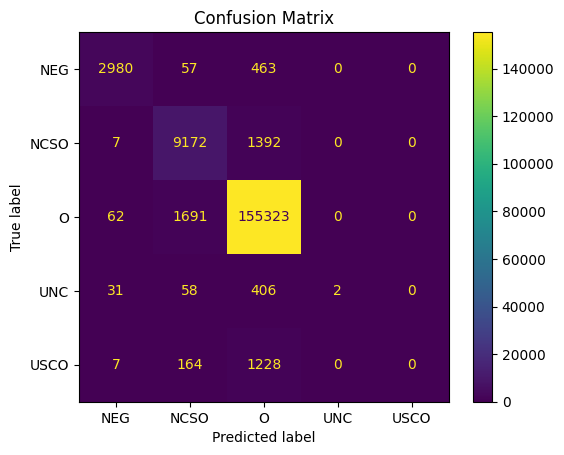

Accuracy: 96.78%
Classification Report:
              precision    recall  f1-score   support

         NEG       0.97      0.85      0.90      3500
        NSCO       0.82      0.87      0.84     10571
           O       0.98      0.99      0.98    157076
         UNC       1.00      0.00      0.01       497
        USCO       0.00      0.00      0.00      1399

    accuracy                           0.97    173043
   macro avg       0.75      0.54      0.55    173043
weighted avg       0.96      0.97      0.96    173043



In [46]:
#wandb.init(project="natural_language", entity = "juliagartor")

model.eval()  # Set the model to evaluation mode

all_val_labels = []
all_predicted_labels = []

for val_inputs, val_labels in val_dataloader:
    batch_inputs_indices.clear()
    batch_labels_indices.clear()

    for token in val_inputs:
        batch_inputs_indices.append(dataset.word_to_index(token))

    for label in val_labels:
        batch_labels_indices.append(dataset.label_to_index(label))

    # Convert batch inputs to a tensor
    batch_inputs_tensor = torch.tensor(batch_inputs_indices)

    # Forward pass
    outputs = model(batch_inputs_tensor)

    # Get the predicted labels
    _, predicted_indices = torch.max(outputs, 1)

    # Convert predicted indices to label format
    predicted_labels = [dataset.index_to_label(index) for index in predicted_indices]

    # Accumulate the labels and predictions
    all_val_labels.extend(val_labels)
    all_predicted_labels.extend(predicted_labels)

# Convert labels to numpy arrays
val_labels_array = np.array(all_val_labels)
predicted_labels_array = np.array(all_predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(val_labels_array, predicted_labels_array)

# Calculate accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)

wandb.log({"Accuracy": accuracy})

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEG","NCSO","O","UNC","USCO"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Print accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Print classification report
print("Classification Report:")
print(classification_report(val_labels_array, predicted_labels_array,zero_division=0))

In [47]:
wandb.finish()

Accuracy,▁
Loss,█████▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Accuracy,0.96783
Loss,0.93002


- Problems and solutions

As it was mentioned in the previous section, we cannot relay on the accuracy. So, we will recompute the loss to put more emphasis in the classes that we want our model to be able to classify better.

In [ ]:
batch_size = 64
embedding_dim = 100
hidden_dim = 150
num_classes = 5  # NEG, UNC, NSCO, USCO, and O.

In [ ]:
wandb.login()

In [ ]:
wandb.init(project="natural_language", entity = "juliagartor")

# Log the hyperparameters
config = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
}
wandb.config.update(config)

In [ ]:
criterion_specific = nn.CrossEntropyLoss(ignore_index = 2)
criterion_full = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    for batch_inputs, batch_labels in train_dataloader:

        batch_inputs_indices.clear()
        batch_labels_indices.clear()

        for token in batch_inputs:
          batch_inputs_indices.append(dataset.word_to_index(token))

        for label in batch_labels:
            batch_labels_indices.append(dataset.label_to_index(label))
        
        #print(batch_inputs_indices)
        #print(batch_labels_indices)

        # Convert batch inputs and labels to tensors
        batch_inputs_tensor = torch.tensor(batch_inputs_indices)
        batch_labels_tensor = torch.tensor(batch_labels_indices)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_inputs_tensor)

        # Compute the loss
        loss_full = criterion_full(outputs, batch_labels_tensor)
        loss_specific = criterion_specific(outputs, batch_labels_tensor)
        loss = loss_full*0.2 + loss_specific*0.8

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)

    # Log the loss for the current epoch
    wandb.log({"Loss": average_loss})

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")


In [ ]:
#wandb.init(project="natural_language", entity = "juliagartor")

model.eval()  # Set the model to evaluation mode

all_val_labels = []
all_predicted_labels = []

for val_inputs, val_labels in val_dataloader:
    batch_inputs_indices.clear()
    batch_labels_indices.clear()

    for token in val_inputs:
        batch_inputs_indices.append(dataset.word_to_index(token))

    for label in val_labels:
        batch_labels_indices.append(dataset.label_to_index(label))

    # Convert batch inputs to a tensor
    batch_inputs_tensor = torch.tensor(batch_inputs_indices)

    # Forward pass
    outputs = model(batch_inputs_tensor)

    # Get the predicted labels
    _, predicted_indices = torch.max(outputs, 1)

    # Convert predicted indices to label format
    predicted_labels = [dataset.index_to_label(index) for index in predicted_indices]

    # Accumulate the labels and predictions
    all_val_labels.extend(val_labels)
    all_predicted_labels.extend(predicted_labels)

# Convert labels to numpy arrays
val_labels_array = np.array(all_val_labels)
predicted_labels_array = np.array(all_predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(val_labels_array, predicted_labels_array)

# Calculate accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)

wandb.log({"Accuracy": accuracy})

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEG","NCSO","O","UNC","USCO"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Print accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Print classification report
print("Classification Report:")
print(classification_report(val_labels_array, predicted_labels_array,zero_division=0))

In [ ]:
wandb.finish()

### $\color{palevioletred}{\text{(3) Third attempt: Finetuning BERT for NER}}$


---

## Conclusions

---